In [1]:
import csv
import pandas

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scikitplot
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pickle

In [2]:

with open('./../Resources/dataset/fer2013.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1


Column names are emotion, pixels, Usage


In [3]:
file_name = './../Resources/dataset/fer2013.csv'
df = pandas.read_csv(file_name)
print(df)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


In [4]:
def getData():
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    first = True

    for line in open(file_name):
        if first:
            first = False
        else:
            row = line.split(',')
            if True:#int(row[0]) == 3 or int(row[0]) == 4:
                if row[2] == "Training\n":
                    Y_train.append(int(row[0]))
                    X_train.append([int(p) for p in row[1].split()])
                else:
                    Y_test.append(int(row[0]))
                    X_test.append([int(p) for p in row[1].split()])

    X_train = np.asarray(X_train, np.float32)
    X_test = np.asarray(X_test, np.float32)
    X_train = X_train / 255
    X_test = X_test / 255
    """
    X1 = []
    for idx in range(len(X_train)):
        X1.append(tf.reshape(tf.convert_to_tensor(X_train[idx], np.float32), [48,48]))
    X_train = X1
    X1 = []
    for idx in range(len(X_test)):
        X1.append(tf.reshape(tf.convert_to_tensor(X_test[idx], np.float32), [48,48]))
    X_test = X1
    """
    
    # Y_train = tf.convert_to_tensor(Y_train)
    # Y_test = tf.convert_to_tensor(Y_test)

    return X_train, Y_train, X_test, Y_test

In [5]:
X_train, Y_train, X_test, Y_test = getData()

In [6]:
def showImage(img):
    img = np.reshape(img, (48, 48))
    plt.imshow(img)
    plt.show()

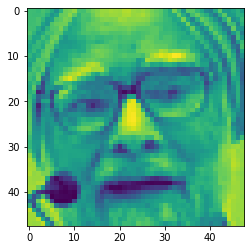

In [7]:
showImage((X_train[1]))

In [8]:
def trainAndSafeModel(file_name, X, Y, input_kernel, input_c, input_gamma):
    clf = svm.SVC(decision_function_shape = 'ovo', kernel= input_kernel, cache_size=2000, C = input_c, gamma= input_gamma)
    print('Kernel: ' + clf.kernel +'\n Cache Size: ' + str(clf.cache_size))
    clf.fit(X, Y)
    with open(file_name, 'wb') as fid:
        pickle.dump(clf, fid)
    return clf

In [50]:
# Signatur: File_name, Input_data, correct_classes, kernel, c, gamma
clf = trainAndSafeModel('all_rbf_c1000_gamma1e-3', X_train, Y_train, 'rbf', 1000, 0.001)

Kernel: rbf
 Cache Size: 2000


In [51]:
clf.predict([X_train[1]])

array([0])

In [52]:
Y_train[1]

0

In [12]:
with open('all_classes_rbf_C10_gamma1e-3', 'rb') as fid:
    clf_loaded = pickle.load(fid)
print('Kernel: ' + clf_loaded.kernel +'\n Cache Size: ' + str(clf_loaded.cache_size)+ '\n Gamma: '+ str(clf_loaded.gamma) + '\n C: ' + str(clf_loaded.C))

Kernel: rbf
 Cache Size: 2000
 Gamma: 0.001
 C: 10


In [13]:
clf_loaded.predict(X_test[50:55])

array([6, 3, 5, 3, 3])

In [14]:
def calculateAccuracy(X, Y, classifier):
    l = len(X)
    i = 0
    for idx in range(l):
        prediction = classifier.predict([X[idx]])
        if prediction == Y[idx]:
            i += 1
    return i / l

In [15]:
calculateAccuracy(X_test,Y_test, clf_loaded)

0.42769573697408747

In [9]:
# Set the Parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    clf = GridSearchCV(svm.SVC(cache_size = 2000), tuned_parameters, scoring='%s_macro' % score
                      )
    clf.fit(X_train[1:2000], Y_train[1:2000])
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the first 200 entries of the development set.")
    print("The scores are computed on the first 200 entries of the evaluation set.")
    print()
    Y_true, Y_pred = Y_test[200], clf.predict(X_test[200])
    print(classification_report(Y_true, Y_pred))
    print()


# Tuning hyper-parameters for precision



/Users/maxlewerenz/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maxlewerenz/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maxlewerenz/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maxlewere

/Users/maxlewerenz/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maxlewerenz/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.181 (+/-0.071) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.035 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.263 (+/-0.032) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.244 (+/-0.110) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.263 (+/-0.088) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.260 (+/-0.044) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.268 (+/-0.086) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.262 (+/-0.059) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.241 (+/-0.032) for {'C': 1, 'kernel': 'linear'}
0.239 (+/-0.036) for {'C': 10, 'kernel': 'linear'}
0.239 (+/-0.036) for {'C': 100, 'kernel': 'linear'}
0.239 (+/-0.036) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the first 200 entries of the development set.
The scores are computed on the first 200 ent

ValueError: Expected 2D array, got 1D array instead:
array=[0.36470589 0.24313726 0.27058825 ... 0.96862745 0.96862745 0.97647059].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [11]:
for i in range

35887